# Multimodal AI exercise 2: Visual Question Answering
In this exercise we will start with our first multimodal approach. Our specific task in this exercise is visual question answering.  
We will apply our knowledge from exercise 1 on how to encode images and learn how to encode language via recurrent neural networks and tranformers.

We start with installing the easy-vqa dataset which we use to train our model and import the required libraries

In [5]:
!pip install easy-vqa
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 13.3 MB/s eta 0:00:00


In [6]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torchinfo import summary
import torchtext
from torchtext.data import get_tokenizer
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

from easy_vqa import get_train_questions, get_test_questions, get_train_image_paths, get_test_image_paths, get_answers

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


### Configs
Here, we define the batch size, learning rate and the number of epochs we want to train

In [7]:
batch_size = 64
learning_rate = 0.001
num_epochs = 40

### Load the Data
With easy-vqa we can easily get the questions, answers, and corresponding image ids

In [8]:
train_qs, train_answers, train_img_ids = get_train_questions()
test_qs, test_answers, test_img_ids = get_test_questions()
print(f"Number of training questions: {len(train_qs)}\nNumber of testing questions: {len(test_qs)}")

train_img_paths = get_train_image_paths()
test_img_paths = get_test_image_paths()

all_answers = get_answers()
num_answers = len(all_answers)
print(f"All possible {num_answers} answers:", all_answers)

Number of training questions: 38575
Number of testing questions: 9673
All possible 13 answers: ['circle', 'green', 'red', 'gray', 'yes', 'teal', 'black', 'rectangle', 'yellow', 'triangle', 'brown', 'blue', 'no']


The following shows how to get the first question, answer and corresponding image

what is the blue shape?
rectangle


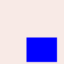

In [9]:
print(train_qs[0])
print(train_answers[0])
display(Image.open(train_img_paths[train_img_ids[0]]))

### Load Word2Vec
Next, we are loading the pretrained word2vec, which serves us as a replacement for the embedding layer

In [ ]:
import string
from gensim.models.word2vec import Word2Vec
import gensim.downloader

pretrained_word2vec = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


word2vec is like a dictionary where the keys are words/tokens and the values are embeddings of dimension (300,)

In [ ]:
print(type(pretrained_word2vec))
print(pretrained_word2vec["shape"].shape)

<class 'gensim.models.keyedvectors.KeyedVectors'>
(300,)


### Exercise 2.1: Preprocess the Questions
Now, we want to apply our loaded word2vec to our questions. Therefore, we need to tokenize each question, remove the stop words, and pad each question to a length of 7 (which is the length of the longest question). And at last, we need to actually apply our loaded 'pretrained_word2vec' to the padded tokens.

In [ ]:
def preprocess_questions(questions):
    tokenizer = get_tokenizer("basic_english")
    stop_words = ["a", "the", "of"]
    qs_embs = []
    max_question_len = 7    # tested by hand
    for question in questions:
        # remove punctuation
        question = question.translate(str.maketrans('', '', string.punctuation))

        # Your code here

    qs_embs = np.asarray(qs_embs)
    return qs_embs

train_qs_idxs = preprocess_questions(train_qs)
print("Train question embeddings shape:", train_qs_idxs.shape)
test_qs_idxs = preprocess_questions(test_qs)
print("Test question embeddings shape:", test_qs_idxs.shape)

### Preprocess the Answers
Of course we also need to preprocess our answers. The following encodes each answer in a one-hot-encoding of all possible answers

In [11]:
# get index of each answer
train_answer_indices = np.array([all_answers.index(a) for a in train_answers])
test_answer_indices = np.array([all_answers.index(a) for a in test_answers])

# create a one-hot encoding for the answers
train_Y = np.zeros((train_answer_indices.size, train_answer_indices.max()+1), dtype=int)
test_Y = np.zeros((test_answer_indices.size, test_answer_indices.max()+1), dtype=int)
# replace 0 with a 1 at the index of the original array
train_Y[np.arange(train_answer_indices.size), train_answer_indices] = 1
test_Y[np.arange(test_answer_indices.size), test_answer_indices] = 1
print(f"one-hot-encoding of answer 0: {train_Y[0]}")

one-hot-encoding of answer 0: [0 0 0 0 0 0 0 1 0 0 0 0 0]


### Exercise 2.2: Create your own custom VQA Dataset
As we preprocessed a lot, there isn't much to do here. Please implement the \_\_init__(...), \_\_get_item__(...), and \_\_len__(...) function. \_\_init__ initializes all required variables. \_\_get_item__ loads the embedded question, the one-hot-encoded answer, loads the corresponding image and applies the given transformation to it. And \_\_len__ returns the length of the dataset.

In [ ]:
class CustomVQADataset(Dataset):
    def __init__(self, img_paths, qs_embs, ans_encodings, qs_img_ids, img_transform):
        # Your code here
        pass

    def __getitem__(self, idx):
        # Your code here
        return

    def __len__(self):
        # Your code here
        return

The following states the image transformations, creates an instance of the training and test set and transforms it to the corresponding DataLoader

In [12]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
train_dataset = CustomVQADataset(train_img_paths, train_qs_idxs, train_Y, train_img_ids, train_transforms)
test_dataset = CustomVQADataset(test_img_paths, test_qs_idxs, test_Y, test_img_ids, test_transforms)
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=4)
testloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
print("Train dataset:", len(train_dataset))
print("Test dataset:", len(test_dataset))

### Exercise 2.3: Create the VQA Model
We need to implement the actual VQA model. For the image encoder we provided the initialization of convolutional and pooling layers.  
Please implement the forward pass! Just apply the convolution with the ReLU activation function followed by a MaxPool operation 3 times. After that, flatten the input (except for the batch dimension) and apply the fully connected layer followed again by ReLU.  

Second, the forward pass for combining both modalities is missing. Please implement it as well. To do that you need to encode the image and the question with the corresponding encoders. Combine both encodings via element-wise multiplication followed by ReLU, the given dropout layer, and feed it though the fully connected layer at last.



In [ ]:
class ImgEncoder(nn.Module):
    def __init__(self, emb_size=32):
        super(ImgEncoder, self).__init__()

        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)   # output shape (batch_size, 8, 62, 62)
        self.pool1 = nn.MaxPool2d(kernel_size=2)      # output shape (batch_size, 8, 31, 31)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)  # output shape (batch_size, 16, 29, 29)
        self.pool2 = nn.MaxPool2d(kernel_size=2)      # output shape (batch_size, 16, 14, 14)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3) # output shape (batch_size, 32, 12, 12)
        self.pool3 = nn.MaxPool2d(kernel_size=2)      # output shape (batch_size, 32, 6, 6)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32*6*6, emb_size)        # output shape (batch_size, 32)

    def forward(self, img):
        # Your code here
        return img


class TextEncoder(nn.Module):
    def __init__(self, word_embed_size=300, hidden_size=32, num_layers=1, emb_size=32):
        super(TextEncoder, self).__init__()

        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(word_embed_size, hidden_size, num_layers)
        self.fc = nn.Linear(2*num_layers*hidden_size, emb_size)      # 2 for hidden and cell states

    def forward(self, txt_embs):
        txt_embs = txt_embs.transpose(0, 1)                           # [qs_length=7, batch_size, word_embed_size=300]
        _, (hidden, cell) = self.lstm(txt_embs)                       # [num_layers=2, batch_size, hidden_size=32]
        qst_feature = torch.cat((hidden, cell), 2)                    # [num_layers=2, batch_size, 2*hidden_size=64]
        qst_feature = qst_feature.transpose(0, 1)                     # [batch_size, num_layers=2, 2*hidden_size=64]
        qst_feature = qst_feature.reshape(qst_feature.size()[0], -1)  # [batch_size, 2*num_layers*hidden_size=64]
        qst_feature = self.relu(qst_feature)
        qst_feature = self.fc(qst_feature)                            # [batch_size, embed_size=32]
        qst_feature = self.relu(qst_feature)
        return qst_feature


class VQA(nn.Module):
    def __init__(self, num_answers, emb_size=32):
        super(VQA, self).__init__()

        self.img_encoder = ImgEncoder(emb_size=emb_size)
        self.txt_encoder = TextEncoder(emb_size=emb_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(emb_size, num_answers)

    def forward(self, img, q):
        # Your code here
        return combined_feature

vqa_model = VQA(num_answers)
vqa_model.to(device)
summary(vqa_model, [(batch_size, 3, 64, 64), (batch_size, 7, 300)])

### Exercise 2.4: Implement the Training and Validation Loop
We give you the trainloader and how to calculate the metrics (loss and accuracy) on the training set (used for better visualization) but the rest of the training loop is missing. Please insert the forward and backward pass and the required optimizer operations.  
Additionally, please implement the validation loop including validation loss and accuracy (remember: no gradients are calculated here 😉)

In [14]:
def train_loop(model, optimizer, criterion, train_loader):
    model.train()
    total_loss, total = 0, 1e-6
    num_correct = 0

    for img, qs, ans in trainloader:
        img, qs, ans =  img.to(device), qs.to(device), ans.to(device, dtype=torch.float32)
        # Your code here
        # (output of the model is called output)

        # Record metrics
        total_loss += loss.item()
        total += len(ans)

        # calculate accuracy
        _, prediction = output.max(1)
        answer = torch.argmax(ans, dim=1)
        num_correct += (prediction == answer).sum()
    return total_loss / total, (num_correct.item() / total) * 100


def validate_loop(model, criterion, valid_loader):
    model.eval()
    total_loss, total = 0, 1e-6
    num_correct = 0
    # Your code here

    return total_loss / total, (num_correct.item() / total) * 100

Define the loss function and optimizer

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vqa_model.parameters(), lr=learning_rate)

## Training
Now we can actually train our VQA model. The model is trained for one epoch always followed by a validation.

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in tqdm(range(num_epochs)):
    train_loss, train_acc = train_loop(vqa_model, optimizer, criterion, trainloader)
    val_loss, val_acc = validate_loop(vqa_model, criterion, testloader)

    tqdm.write(
        f' epoch#{epoch + 1:3d}\ttrain_loss: {train_loss:.2e}\ttrain_acc: {train_acc:.2f}\tval_loss: {val_loss:.2e}\tval_acc: {val_acc:.2f}\n',
    )

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

### Show Training Performance
Lets take a look at the loss and accuarcy curves of our training

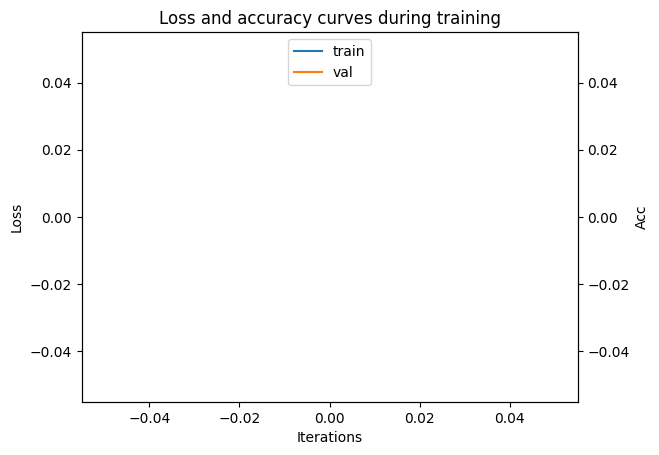

In [17]:
def plot_loss_curve(train_loss, val_loss, train_acc, val_acc):
    fig, ax1 = plt.subplots()
    ax1.plot(train_loss, label="train")
    ax1.plot(val_loss, label="val")
    ax1.legend(loc="upper center")
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax2 = ax1.twinx()
    ax2.plot(train_acc, color="blue", linestyle="dashed")
    ax2.plot(val_acc, color="orange", linestyle="dashed")
    ax2.set_ylabel("Acc")
    plt.title("Loss and accuracy curves during training")
    plt.show()

plot_loss_curve(train_losses, val_losses, train_accs, val_accs)

## Transformers
After we used the RNN approach, lets use Transformers 🚀  

In [18]:
# Configs
batch_size = 64
learning_rate = 0.001
num_epochs = 40

Here, the positional encoding is added to the input embeddings

In [19]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model%2 != 0:
            pe[:, 1::2] = torch.cos(position * div_term)[:,0:-1]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

### Exercise 2.5: Self-Attention
We provide the implementation of running multi-head-attention but the actual **attention calculation is missing**. Please implement the scaled_dot_product_attention(self, Q, K, V)!

In [20]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V):
        # Your code here
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [21]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

### Exercise 2.6: Assemble the Transformer Encoder
Now, we need to put everything together. Implement the forward pass as given in the lecture.
Additionally, apply dropout to the attention output and feed forward output.

In [22]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Your code here
        return x

### The Transformer VQA Model
We use the same model as before but replace the LSTM with a Transformer layer.  
<font color='red'>Remember</font> that combining both modalities is missing, just take the same part of code you implemented for the LSTM based VQA model.

In [ ]:
class ImgEncoder(nn.Module):
    def __init__(self, emb_size=32):
        super(ImgEncoder, self).__init__()

        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)   # output shape (batch_size, 8, 62, 62)
        self.pool1 = nn.MaxPool2d(kernel_size=2)      # output shape (batch_size, 8, 31, 31)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)  # output shape (batch_size, 16, 29, 29)
        self.pool2 = nn.MaxPool2d(kernel_size=2)      # output shape (batch_size, 16, 14, 14)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3) # output shape (batch_size, 32, 12, 12)
        self.pool3 = nn.MaxPool2d(kernel_size=2)      # output shape (batch_size, 32, 6, 6)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32*6*6, emb_size)        # output shape (batch_size, 32)

    def forward(self, img):
        x = self.pool1(self.relu(self.conv1(img)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = x.view(-1, 32*6*6)
        x = self.relu(self.fc1(x))
        return x


class TransTextEncoder(nn.Module):
    def __init__(self, word_embed_size=300, hidden_size=64, emb_size=32):
        super(TransTextEncoder, self).__init__()
        dropout = 0.5
        self.word_emb_dim = word_embed_size
        self.pos_encoder = PositionalEncoding(word_embed_size, dropout)
        self.transformer_encoder = EncoderLayer(word_embed_size, num_heads=10, d_ff=hidden_size, dropout=dropout)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(word_embed_size, emb_size)

    def forward(self, txt_embs):
        txt_embs = txt_embs * math.sqrt(self.word_emb_dim)
        txt_embs = self.pos_encoder(txt_embs)
        qst_feature = self.transformer_encoder(txt_embs)
        qst_feature = self.relu(qst_feature)
        qst_feature = qst_feature.max(dim=1)[0]
        qst_feature = self.fc(qst_feature)
        return qst_feature


class TransformerVQA(nn.Module):
    def __init__(self, num_answers, emb_size=32):
        super(TransformerVQA, self).__init__()

        self.img_encoder = ImgEncoder(emb_size=emb_size)
        self.txt_encoder = TransTextEncoder(emb_size=emb_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(emb_size, num_answers)

    def forward(self, img, q):
        # Your code here
        return combined_feature

trans_vqa_model = TransformerVQA(num_answers)
trans_vqa_model.to(device)
summary(trans_vqa_model, [(batch_size, 3, 64, 64), (batch_size, 7, 300)])

### Train the Transformer
Lets see how your transformer performs in comparison to the LSTM approach

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(trans_vqa_model.parameters(), lr=learning_rate)

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in tqdm(range(num_epochs)):
    train_loss, train_acc = train_loop(trans_vqa_model, optimizer, criterion, trainloader)
    val_loss, val_acc = validate_loop(trans_vqa_model, criterion, testloader)

    tqdm.write(
        f' epoch#{epoch + 1:3d}\ttrain_loss: {train_loss:.2e}\ttrain_acc: {train_acc:.2f}\tval_loss: {val_loss:.2e}\tval_acc: {val_acc:.2f}\n',
    )

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

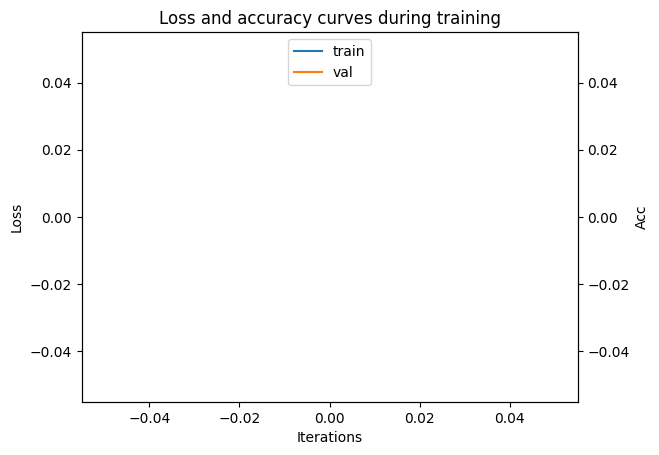

In [26]:
plot_loss_curve(train_losses, val_losses, train_accs, val_accs)

### Bonus Exercise 2.6
After the model is working now, try to confuse it, e.g.
- zero out all image pixels or
- assign a random image to a question-answer pair or
- permute the word order in the questions

How does it affect the model performance? What does it say about the data?  

Can you verify your assumptions?